In [46]:
from matplotlib import pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np
import seaborn as sns

In [2]:
# path to BLEU etc.
p = Path('/eagle/projects/argonne_tpc/siebenschuh/aurora_gpt/database/out_table_reduced_ALL.csv')

# exclude text-columns
headers = [*pd.read_csv(p, sep='|', nrows=1)]
df = pd.read_csv(p, sep='|', usecols=[c for c in headers if c not in {'html', 'nougat', 'pymupdf', 'grobid'}])

## Descriptive statistics of the dataset

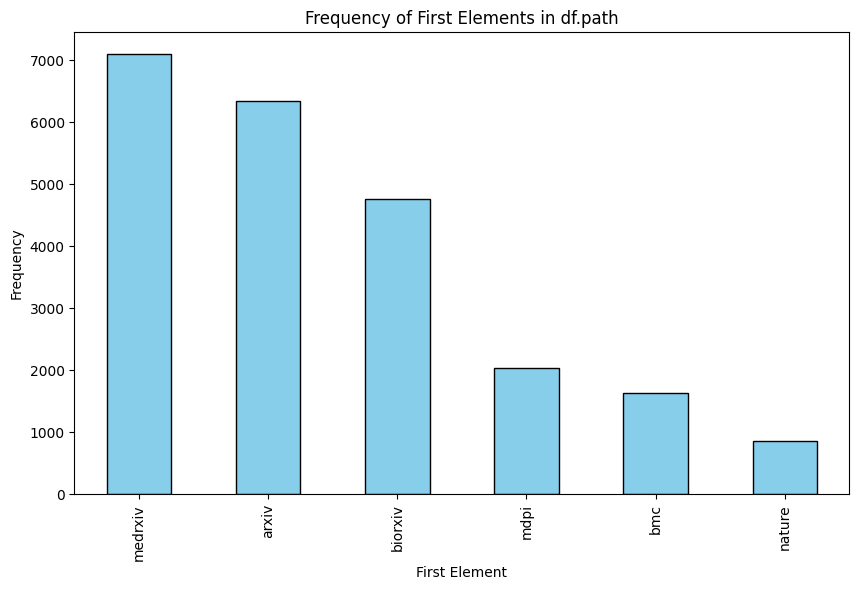

In [3]:
first_elements = df['path'].str.split('/').str[0]

# Step 3: Count the occurrences of each unique value
value_counts = first_elements.value_counts()

# Step 4: Plot the results as a bar chart
value_counts.plot(kind='bar', figsize=(10, 6), color='skyblue', edgecolor='black')

# Add labels and title
plt.title('Frequency of First Elements in df.path')
plt.xlabel('First Element')
plt.ylabel('Frequency')

# Show the plot
plt.show()

## Question 1a: How does parser output quality vary (if any)

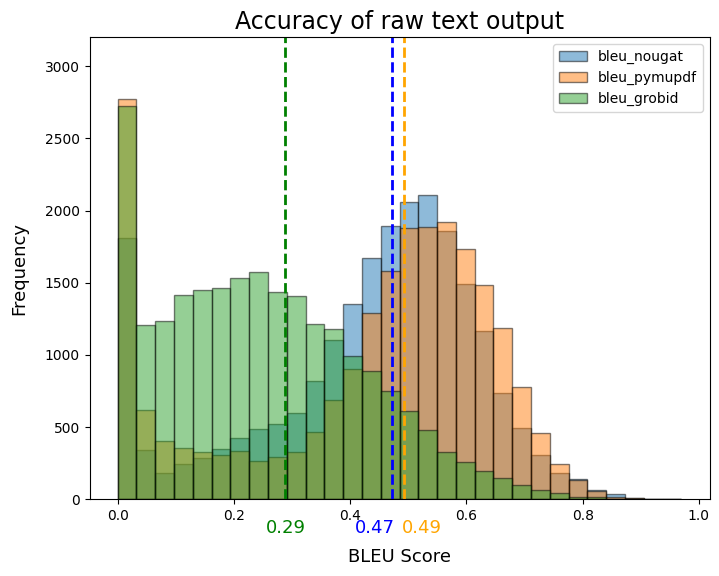

In [4]:
# Step 1: Filter the DataFrame to exclude values smaller than 0.05 for mean calculation
filtered_df = df[['bleu_nougat', 'bleu_pymupdf', 'bleu_grobid']].apply(lambda x: x[x >= 0.05])

# Step 2: Calculate the conditional mean for each column
means = filtered_df.mean()

# Step 3: Plot histograms for the entire dataset (not just the filtered one)
ax = df[['bleu_nougat', 'bleu_pymupdf', 'bleu_grobid']].plot.hist(alpha=0.5, bins=30, edgecolor='black', figsize=(8, 6))

# Step 4: Add vertical lines for the conditional mean with corresponding colors
colors = ['blue', 'orange', 'green']  # The default colors used by pandas

for i, (mean, color) in enumerate(zip(means, colors)):
    plt.axvline(mean, color=color, linestyle='dashed', linewidth=2)
    # visually disentangle similar values
    if mean > 0.3:
        if i % 2 == 0:
            x_offset = -0.03  # Shift left
        else:
            x_offset = 0.03   # Shift right
    else:
        x_offset = 0.0
    
    plt.text(mean + x_offset, 
             plt.gca().get_ylim()[0] - plt.gca().get_ylim()[1] * 0.08, 
             f'{mean:.2f}', color=color, ha='center', fontsize=13)

# Add labels and title
plt.title(r'Accuracy of raw text output', fontsize=17)
plt.xlabel('BLEU Score', labelpad=18, fontsize=13)
plt.ylabel('Frequency', labelpad=12, fontsize=13)
plt.ylim(0,3200)

# Show the plot
plt.show()

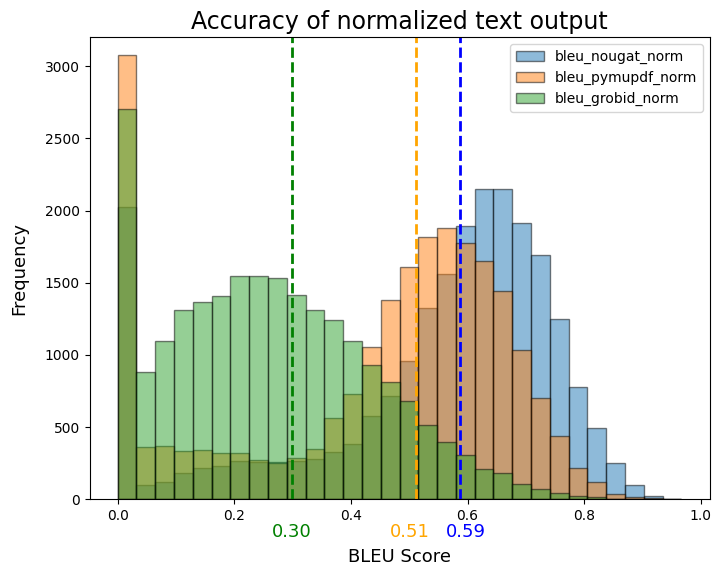

In [5]:
# Step 1: Filter the DataFrame to exclude values smaller than 0.05 for mean calculation
filtered_df = df[['bleu_nougat_norm', 'bleu_pymupdf_norm', 'bleu_grobid_norm']].apply(lambda x: x[x >= 0.05])

# Step 2: Calculate the conditional mean for each column
means = filtered_df.mean()

# Step 3: Plot histograms for the entire dataset (not just the filtered one)
ax = df[['bleu_nougat_norm', 'bleu_pymupdf_norm', 'bleu_grobid_norm']].plot.hist(alpha=0.5, bins=30, edgecolor='black', figsize=(8, 6))

# Step 4: Add vertical lines for the conditional mean with corresponding colors
colors = ['blue', 'orange', 'green']  # The default colors used by pandas

for i, (mean, color) in enumerate(zip(means, colors)):
    plt.axvline(mean, color=color, linestyle='dashed', linewidth=2)
    # visually disentangle similar values
    if mean > 0.3:
        if i % 2 == 0:
            x_offset = 0.01  # Shift left
        else:
            x_offset = -0.01   # Shift right
    else:
        x_offset = 0.0
    
    plt.text(mean + x_offset, 
             plt.gca().get_ylim()[0] - plt.gca().get_ylim()[1] * 0.08, 
             f'{mean:.2f}', color=color, ha='center', fontsize=13)

# Add labels and title
plt.title(r'Accuracy of normalized text output', fontsize=17)
plt.xlabel('BLEU Score', labelpad=18, fontsize=13)
plt.ylabel('Frequency', labelpad=12, fontsize=13)
plt.ylim(0,3200)

# Show the plot
plt.show()

In [6]:
def plot_smoothed_bleu_scores(df, q=0.1, normalized_flag:bool=False):
    # Plot 'bleu_nougat_norm' with confidence band
    if normalized_flag:
        bleu_nougat_column = 'bleu_nougat_norm'
        bleu_pymupdf_column = 'bleu_pymupdf_norm'
        bleu_grobid_column = 'bleu_grobid_norm'
    else:
        bleu_nougat_column = 'bleu_nougat'
        bleu_pymupdf_column = 'bleu_pymupdf'
        bleu_grobid_column = 'bleu_grobid'

    # compute means
    df['bleu_norm_mean'] = df[[bleu_nougat_column, bleu_pymupdf_column, bleu_grobid_column]].mean(axis=1)

    # Step 1: Sort the DataFrame by 'bleu_norm_mean' in descending order
    df_sorted = df.sort_values(by='bleu_norm_mean', ascending=False).reset_index(drop=True)

    
    # Step 2: Apply a rolling mean to smooth the time series (e.g., window of 500)
    df_smoothed = df_sorted[[bleu_nougat_column, bleu_pymupdf_column, bleu_grobid_column]].rolling(window=500, min_periods=1).mean()
    
    # Calculate the rolling quantiles for confidence intervals
    df_lower = df_sorted[[bleu_nougat_column, bleu_pymupdf_column, bleu_grobid_column]].rolling(window=500, min_periods=1).quantile(q)
    df_upper = df_sorted[[bleu_nougat_column, bleu_pymupdf_column, bleu_grobid_column]].rolling(window=500, min_periods=1).quantile(1 - q)
    
    # Step 3: Plot the smoothed time series with confidence bands
    plt.figure(figsize=(10, 6))
    
    plt.plot(df_smoothed.index, df_smoothed[bleu_nougat_column], label=bleu_nougat_column, color='blue')
    plt.fill_between(df_smoothed.index, df_lower[bleu_nougat_column], df_upper[bleu_nougat_column], color='blue', alpha=0.3)
    
    # Plot 'bleu_pymupdf_norm' with confidence band
    plt.plot(df_smoothed.index, df_smoothed[bleu_pymupdf_column], label=bleu_pymupdf_column, color='orange')
    plt.fill_between(df_smoothed.index, df_lower[bleu_pymupdf_column], df_upper[bleu_pymupdf_column], color='orange', alpha=0.3)
    
    # Plot 'bleu_grobid_norm' with confidence band
    plt.plot(df_smoothed.index, df_smoothed[bleu_grobid_column], label=bleu_grobid_column, color='green')
    plt.fill_between(df_smoothed.index, df_lower[bleu_grobid_column], df_upper[bleu_grobid_column], color='green', alpha=0.3)
    
    # Adding labels and title
    plt.xlabel('Hardness to parse the PDF', labelpad=18)
    plt.ylabel('BLEU Score')
    
    # Conditionally set the title
    if normalized_flag:
        plt.title('Smoothed BLEU Scores by Method with Confidence Bands')
    else:
        plt.title('Smoothed BLEU Scores of Normalized Text by Method with Confidence Bands')
    
    plt.legend()

    # Modify the x-axis: remove tick labels but keep the tick lines
    plt.gca().set_xticklabels([])

    # Add the "Easy" and "Hard" text labels
    plt.text(0.15 * len(df_smoothed), plt.gca().get_ylim()[1] * -0.1, 'Easy', ha='center', fontsize=10)
    plt.text(0.50 * len(df_smoothed), plt.gca().get_ylim()[1] * -0.1, 'Medium', ha='center', fontsize=10)
    plt.text(0.85 * len(df_smoothed), plt.gca().get_ylim()[1] * -0.1, 'Hard', ha='center', fontsize=10)

    # Show the plot
    plt.show()

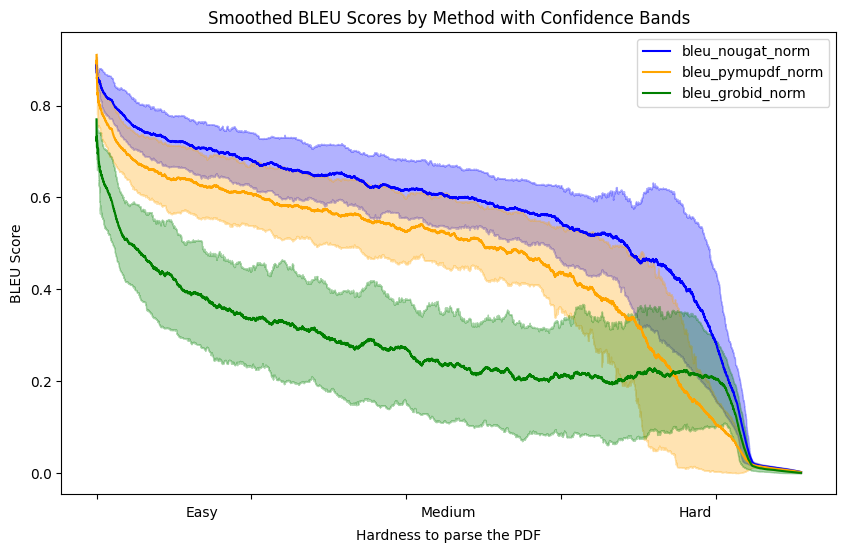

In [7]:
# Example usage with a quantile parameter q=0.35
plot_smoothed_bleu_scores(df, 0.2, True)

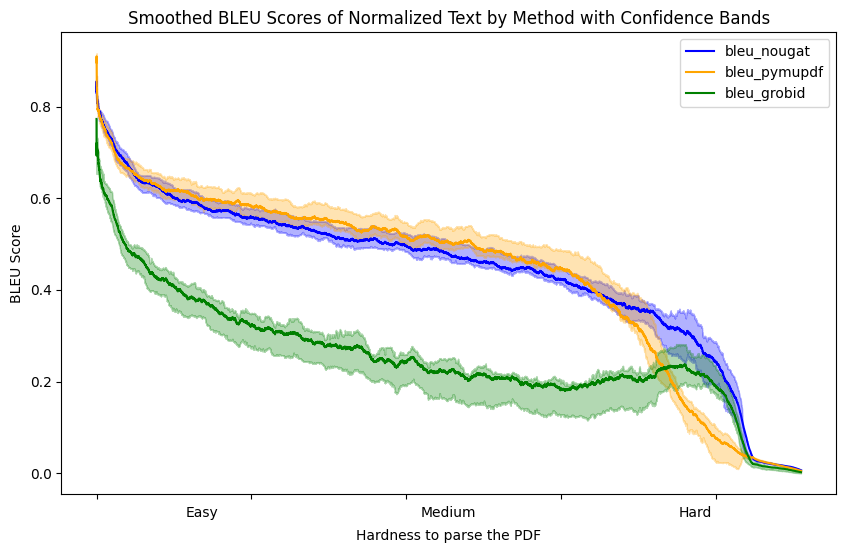

In [8]:
plot_smoothed_bleu_scores(df, 0.4, False)

In [9]:
bleu_nougat_column = 'bleu_nougat_norm'
bleu_pymupdf_column = 'bleu_pymupdf_norm'
bleu_grobid_column = 'bleu_grobid_norm'

df['bleu_norm_mean'] = df[[bleu_nougat_column, bleu_pymupdf_column, bleu_grobid_column]].mean(axis=1)

df_sorted = df.sort_values(by='bleu_norm_mean', ascending=False).reset_index(drop=True)

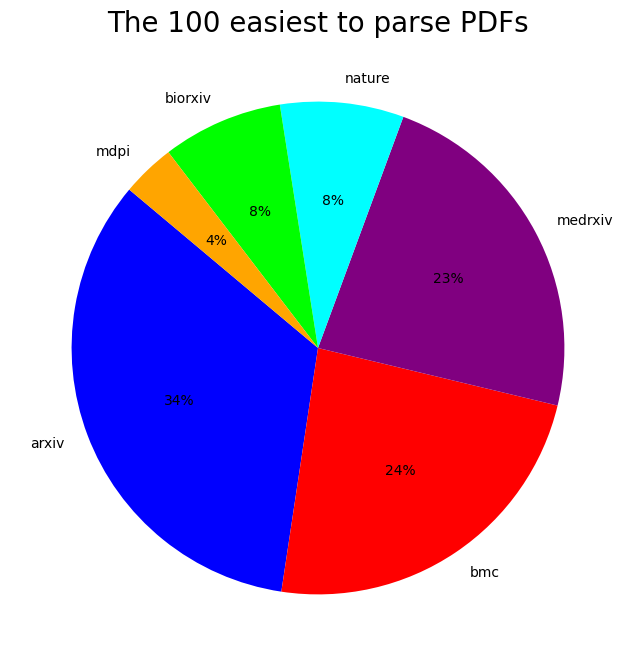

In [10]:
# Extract the first element from the 'path' column after splitting by '/'
first_elements = df_sorted[:1000]['path'].str.split('/').str[0]
value_counts = first_elements.value_counts()

color_map = {
    'bmc': '#FF0000',
    'arxiv': '#0000FF',
    'biorxiv': '#00FF00',
    'mdpi' : '#FFA500',
    'medrxiv': '#800080',
    'nature': '#00FFFF',
}

colors = [color_map.get(label, 'gray') for label in value_counts.index]

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(value_counts, labels=value_counts.index, colors=colors, autopct='%1.f%%', startangle=140)

# Add title
plt.title('The 100 easiest to parse PDFs', fontsize=20)

# Show the plot
plt.show()

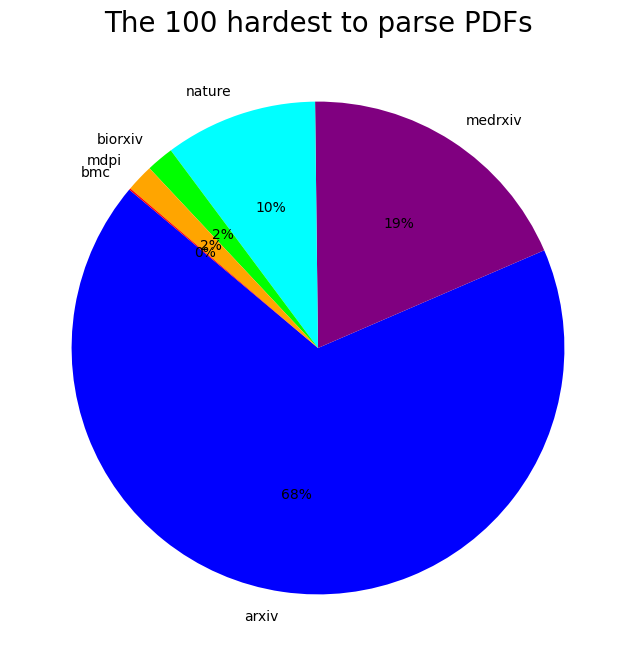

In [11]:
# Extract the first element from the 'path' column after splitting by '/'
first_elements = df_sorted[-1000:]['path'].str.split('/').str[0]
value_counts = first_elements.value_counts()

color_map = {
    'bmc': '#FF0000',
    'arxiv': '#0000FF',
    'biorxiv': '#00FF00',
    'mdpi' : '#FFA500',
    'medrxiv': '#800080',
    'nature': '#00FFFF',
}

colors = [color_map.get(label, 'gray') for label in value_counts.index]

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(value_counts, labels=value_counts.index, colors=colors, autopct='%1.f%%', startangle=140)

# Add title
plt.title('The 100 hardest to parse PDFs', fontsize=20)

# Show the plot
plt.show()

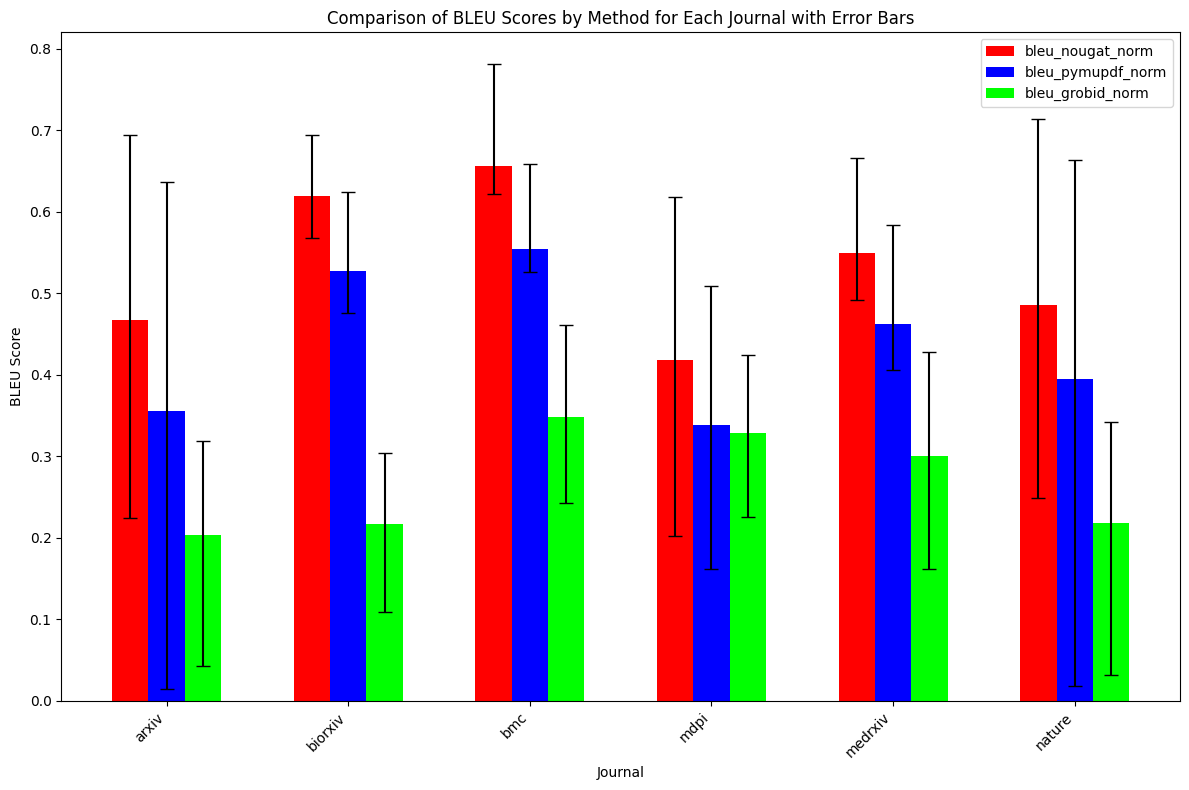

In [41]:
def plot_grouped_bar_chart_with_error_bars(df, quantile=0.25, normalized_flag:bool=False):
    if normalized_flag:
        bleu_nougat_column = 'bleu_nougat_norm'
        bleu_pymupdf_column = 'bleu_pymupdf_norm'
        bleu_grobid_column = 'bleu_grobid_norm'
    else:
        bleu_nougat_column = 'bleu_nougat'
        bleu_pymupdf_column = 'bleu_pymupdf'
        bleu_grobid_column = 'bleu_grobid'
        
    df_new = df.copy()
    df_new['journal'] = df['path'].str.split('/').str[0]
    df_new = df_new[['journal', bleu_nougat_column, bleu_pymupdf_column, bleu_grobid_column]]

    # Step 1: Group the data by 'journal' and calculate the mean and quantiles for each group
    df_grouped = df_new.groupby('journal', as_index=True)[[bleu_nougat_column, bleu_pymupdf_column, bleu_grobid_column]].mean()
    df_lower = df_new.groupby('journal', as_index=True)[[bleu_nougat_column, bleu_pymupdf_column, bleu_grobid_column]].quantile(quantile)
    df_upper = df_new.groupby('journal', as_index=True)[[bleu_nougat_column, bleu_pymupdf_column, bleu_grobid_column]].quantile(1 - quantile)
    
    # Calculate error bars
    error_bars = {
        bleu_nougat_column: [df_grouped[bleu_nougat_column] - df_lower[bleu_nougat_column], df_upper[bleu_nougat_column] - df_grouped[bleu_nougat_column]],
        bleu_pymupdf_column: [df_grouped[bleu_pymupdf_column] - df_lower[bleu_pymupdf_column], df_upper[bleu_pymupdf_column] - df_grouped[bleu_pymupdf_column]],
        bleu_grobid_column: [df_grouped[bleu_grobid_column] - df_lower[bleu_grobid_column], df_upper[bleu_grobid_column] - df_grouped[bleu_grobid_column]],
    }

    # Step 2: Plot the grouped bar chart with error bars
    fig, ax = plt.subplots(figsize=(12, 8))

    # Set the positions and width for the bars
    x = np.arange(df_grouped.shape[0])  # Use the shape directly for speed
    width = 0.2  # the width of the bars

    # Plot each set of bars with error bars
    ax.bar(x - width, df_grouped[bleu_nougat_column], width, label=bleu_nougat_column, color='#FF0000', 
           yerr=error_bars[bleu_nougat_column], capsize=5)  # Red
    ax.bar(x, df_grouped[bleu_pymupdf_column], width, label=bleu_pymupdf_column, color='#0000FF', 
           yerr=error_bars[bleu_pymupdf_column], capsize=5)  # Blue
    ax.bar(x + width, df_grouped[bleu_grobid_column], width, label=bleu_grobid_column, color='#00FF00', 
           yerr=error_bars[bleu_grobid_column], capsize=5)  # Green

    # Adding labels, title, and custom x-axis tick labels
    ax.set_xlabel('Journal')
    ax.set_ylabel('BLEU Score')
    ax.set_title('Comparison of BLEU Scores by Method for Each Journal with Error Bars')
    ax.set_xticks(x)
    ax.set_xticklabels(df_grouped.index, rotation=45, ha='right')
    ax.legend()

    # Optimize layout for faster rendering
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage with a quantile parameter controlling the error bars
plot_grouped_bar_chart_with_error_bars(df, quantile=0.25, normalized_flag=True) # 0.25 <-> IQR

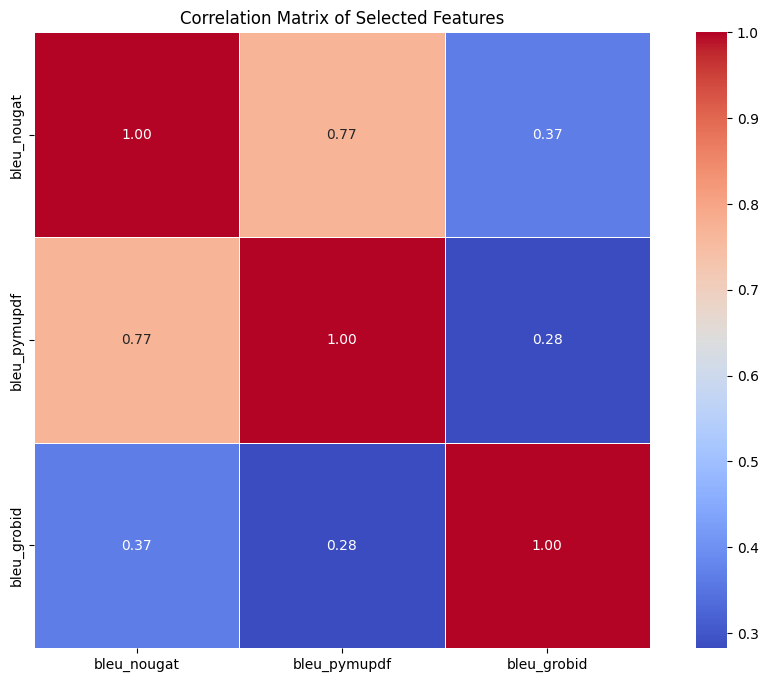

In [53]:
columns_of_interest = [
    'bleu_nougat', 'bleu_pymupdf', 'bleu_grobid'
]

df_selected = df[columns_of_interest]

# Step 2: Calculate the correlation matrix
corr_matrix = df_selected.corr()

# Step 3: Plot the correlation matrix using seaborn heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True, linewidths=0.5)

# Add title
plt.title('Correlation Matrix of Selected Features')

# Show the plot
plt.show()

In [72]:
df_inac = df[df['bleu_norm_mean'] < 0.05]
#df_inac = df_inac[['path', 'grobid_norm', 'nougat_norm', 'pymupdf_norm', 'html_norm', 'bleu_norm_mean']]

In [78]:
df_inac.iloc[0]

Unnamed: 0                                                         207
path                                         arxiv/pdf/1009.1049v1.pdf
grobid_norm          the evolution of organismal populations is not...
nougat_norm          abstract the evolution of organismal populatio...
pymupdf_norm         lcs evolvable frontiers 1 lagrangian coherent ...
html_norm            1 introduction the composition of planetesimal...
bleu_nougat                                                   0.025803
bleu_nougat_norm                                              0.016254
bleu_pymupdf                                                  0.024811
bleu_pymupdf_norm                                             0.017343
bleu_grobid                                                    0.00276
bleu_grobid_norm                                              0.002469
bleu_norm_mean                                                0.012022
journal                                                          arxiv
Name: 

In [73]:
df_inac.iloc[0]['html_norm'][:5000] #['nougat_norm']

'1 introduction the composition of planetesimals comets and eventually planets is determined in large part by the composition of their building blocks icecoated dust grains ices are the dominant carriers of volatiles in planetforming regions pontoppidan et al 2014 walsh et al 2015 and set for a large part the spatial distribution of volatiles in the disk mcclure 2019 banzatti et al 2020 sturm et al 2022 banzatti et al 2023 ices not only play a crucial role in the disk chemistry but also in planet formation processes eg öberg bergin 2016 drżkowska et al 2016 unlike the gas present in the protoplanetary disk ices are directly incorporated into the cores of planets comets and icy moons öberg et al 2023b mapping ices in disks at different stages of their evolution is therefore important to understand the initial building blocks available for planet formation with the advent of the james webb space telescope jwst we are in the unique position to target the ice absorption bands in the midinf

In [74]:
df_inac.iloc[0]['grobid_norm'][:5000]

'the evolution of organismal populations is not typically thought of in terms of classical mechanics however many of the conceptual models used to approximate evolutionary trajectories have implicit parallels to dynamic physical systems the parallels between currentlyused evolutionary models and a type of model related to lagrangian coherent structures lcs will be explored the limits of evolvability in a population can be treated in a way analogous to fronts waves and other aggregate formations observed in fluid dynamics various measures and architectural features will be introduced relevant scenarios include socalled evolvable boundaries and related scenarios involving evolutionary neutrality such as migrations demographic bottlenecks and island biogeography the lcslike model introduced here could eventually be applied to a wide range of problems that normally utilize forms of evolutionary modelingintroductionevolutionary processes and their major features have commonalities with phys

In [75]:
df_inac.iloc[0]['nougat_norm'][:5000]

'abstract the evolution of organismal populations is not typically thought of in terms of classical mechanics however many of the conceptual models used to approximate evolutionary trajectories have implicit parallels to dynamic physical systems the parallels between currentlyused evolutionary models and a type of model related to lagrangian coherent structures lcs will be explored the limits of evolvability in a population can be treated in a way analogous to fronts waves and other aggregate formations observed in fluid dynamics various measures and architectural features will be introduced relevant scenarios include socalled evolvable boundaries and related scenarios involving evolutionary neutrality such as migrations demographic bottlenecks and island biogeography the lcslike model introduced here could eventually be applied to a wide range of problems that normally utilize forms of evolutionary modeling lagrangian coherent structures lcs may describe evolvable frontiers in natural

In [77]:
df_inac.iloc[0]['pymupdf_norm'][:5000]

'lcs evolvable frontiers 1 lagrangian coherent structures lcs may describe evolvable frontiers in natural populations bradly alicea department of animal science michigan state university bradlyaliceaieeeorg keywords lagrangian coherent structures evolutionary systems artificial life theoretical biology abstract the evolution of organismal populations is not typically thought of in terms of classical mechanics however many of the conceptual models used to approximate evolutionary trajectories have implicit parallels to dynamic physical systems the parallels between currently used evolutionary models and a type of model related to lagrangian coherent structures lcs will be explored the limits of evolvability in a population can be treated in a way analogous to fronts waves and other aggregate formations observed in fluid dynamics various measures and architectural features will be introduced relevant scenarios include socalled evolvable boundaries and related scenarios involving evolutio

In [76]:
df_inac.iloc[0]

Unnamed: 0                                                         207
path                                         arxiv/pdf/1009.1049v1.pdf
grobid_norm          the evolution of organismal populations is not...
nougat_norm          abstract the evolution of organismal populatio...
pymupdf_norm         lcs evolvable frontiers 1 lagrangian coherent ...
html_norm            1 introduction the composition of planetesimal...
bleu_nougat                                                   0.025803
bleu_nougat_norm                                              0.016254
bleu_pymupdf                                                  0.024811
bleu_pymupdf_norm                                             0.017343
bleu_grobid                                                    0.00276
bleu_grobid_norm                                              0.002469
bleu_norm_mean                                                0.012022
journal                                                          arxiv
Name: 